# ⛔️ Traffic Signs Detection with YOLO v3, OpenCV and Keras

# 📥 Importing needed libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle

from keras.models import load_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(os.listdir('../input'))

# Any results we write to the current directory are saved as output


['.ipynb_checkpoints', '1.jpeg', '1st_screen.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', 'car-data', 'model3x3', 'model5x5', 'modele', 'result.mp4', 'traffic-signs-dataset-in-yolo-format', 'traffic-signs-detection-by-yolo-v3 - original.ipynb', 'traffic-signs-detection-by-yolo-v3.ipynb', 'traffic-signs-preprocessed', 'yolo_weights', '_archives']


# 📂 Loading *labels*

In [2]:
# Reading csv file with labels' names
# Loading two columns [0, 1] into Pandas dataFrame
labels = pd.read_csv('../input/traffic-signs-preprocessed/label_names.csv')

# Check point
# Showing first 5 rows from the dataFrame
print(labels.head())
print()

# To locate by class number use one of the following
# ***.iloc[0][1] - returns element on the 0 column and 1 row
print(labels.iloc[0][1])  # Speed limit (20km/h)
# ***['SignName'][1] - returns element on the column with name 'SignName' and 1 row
print(labels['SignName'][1]) # Speed limit (30km/h)


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (30km/h)


# 📍 Loading trained Keras CNN model for Classification

In [3]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
#model = load_model('../input/model3x3/model-3x3.h5')
# Better CNN model (larger resolution of filter)
#model = load_model('../input/model5x5/model-5x5.h5')
# Najbetter (uczony na 10k)
model = load_model('../input/modele/model-3x3 (1).h5')

# Loading mean image to use for preprocessing further
# Opening file for reading in binary mode
with open('../input/traffic-signs-preprocessed/mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  # dictionary type
    
print(mean['mean_image_rgb'].shape)  # (3, 32, 32)


(3, 32, 32)


In [4]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_15 (Dense)            (None, 500)               4096500   
                                                                 
 dense_16 (Dense)            (None, 43)                21543     
                                                                 
Total params: 4,118,939
Trainable params: 4,118,939
Non-trainable params: 0
____________________________________________

## Parsing markings dataset

In [5]:
import math
import random
from PIL import Image

path_prefix = "/root/darknet/rmarkings"
validate_percentage = 0.2

def RepresentsInt(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def parse():
    train = {}
    validate = {}
    cls_labels = {}
    
    # Read data
    with open('dataset_annotations.txt') as file:
        classes = {}
        for line in file.readlines():
            lines = line.strip().split(",")
            file_name, clas_spec = lines[-1], lines[-2]
            file_name = file_name.replace(".png", ".jpg")

            xs = [int(float(lines[0])), int(float(lines[2])), int(float(lines[4])), int(float(lines[6]))]
            ys = [int(float(lines[1])), int(float(lines[3])), int(float(lines[5])), int(float(lines[7]))]

            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)

            width = x_max - x_min
            height = y_max - y_min

            im = Image.open(file_name)
            im_width, im_height = im.size

            center_x, center_y = (width / 2) + x_min, (height /2) + y_min

            if classes.get(clas_spec) is None:
                classes[clas_spec] = []
            data = {"name": file_name, "x": center_x / im_width, "y": center_y / im_height, "width": width / im_width, "height": height / im_height}
            classes[clas_spec].append(data)
            print(data)
        
        it = 0
        for key, values in classes.items():
            if len(values) > 20 and not RepresentsInt(key):
                cls_labels[it] = key
                random.shuffle(values)
                test_len = math.floor(len(values) * validate_percentage)
                train[key] = values[-(len(values) - test_len):]
                validate[key] = values[:test_len]


                print(f"validate: {key}: {len(validate[key])}")
                print(f"train: {key}: {len(train[key])}")

                for value in values:
                    f_name = value["name"].replace(".jpg", ".txt")
                    with open(f_name, "w+") as w_file:
                        w_file.write(f"{it} {value['x']} {value['y']} {value['width']} {value['height']}\n")
                it += 1

    with open("classes.names", "w+") as cls_file:
        for cls_name in cls_labels.values():
            cls_file.write(f"{cls_name}\n")

    with open("train.txt", "w+") as data_file:
        for vls in train.values():
            for val in vls:
                data_file.write(f"{path_prefix}/{val['name']}\n")

    with open("test.txt", "w+") as data_file:
        for vls in validate.values():
            for val in vls:
                data_file.write(f"{path_prefix}/{val['name']}\n")
    
    with open("data.data", "w+") as data_file:
        data_file.write(f"""classes = {len(cls_labels.keys())}
train = {path_prefix}/train.txt
valid = {path_prefix}/test.txt
names = {path_prefix}/classes.names
backup = backup1""")

## Loading *trained weights* and *cfg file* into the Network

In [6]:
# Trained weights can be found in the course mentioned above
# Tutaj po dodaniu do Data zmień drogę do pliku który wrzucisz
path_to_weights = '../input/car-data/znaki_rtx_final.weights'
path_to_weights_markings = '../input/car-data/poziome_rtx_final.weights'
path_to_cfg = '../input/traffic-signs-dataset-in-yolo-format/yolov3_ts_test.cfg'
path_to_cfg_markings = '../input/car-data/markings_test.cfg'

# Loading trained YOLO v3 weights and cfg configuration file by 'dnn' library from OpenCV
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)
network_markings = cv2.dnn.readNetFromDarknet(path_to_cfg_markings, path_to_weights_markings)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)

network_markings.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network_markings.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)


## Getting *output layers* where detections are made

In [7]:
# Getting names of all YOLO v3 layers
layers_all = network.getLayerNames()
# layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()] ## закомментил
layers_names_output = [layers_all[i - 1] for i in network.getUnconnectedOutLayers()]
print(layers_names_output)

print("<===========>")

# Getting names of all YOLO v4 layers
layers_all_markings = network_markings.getLayerNames()
layers_names_output_markings = [layers_all_markings[i - 1] for i in network_markings.getUnconnectedOutLayers()]
print(layers_names_output_markings)


['yolo_82', 'yolo_94', 'yolo_106']
<===========>
['yolo_139', 'yolo_150', 'yolo_161']


## Setting *probability*, *threshold* and *colour* for bounding boxes

In [8]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.1

# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.1

# Generating colours for bounding boxes
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
colours_markings = np.random.randint(0, 255, size=(1, 3), dtype='uint8')

# Check point
print(type(colours))  # <class 'numpy.ndarray'>
print(colours.shape)  # (43, 3)
print(colours[0])  # [25  65 200]


<class 'numpy.ndarray'>
(43, 3)
[ 61  71 127]


# 🎬 Reading input video

In [9]:
# Reading video from a file by VideoCapture object
# ../input/testyolo/1.mp4
# video = cv2.VideoCapture('../input/testyolo/1.mp4')

# video = cv2.VideoCapture('../input/car-data/70maiMiniDashCam-Dzien.mp4')
# video = cv2.VideoCapture('../input/car-data/DODRX8W(lusterko)-roadtestwsonecznydzien_podsonce1080p30.mp4')
video = cv2.VideoCapture('../input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4')

# Writer that will be used to write processed frames
writer = None

# Variables for spatial dimensions of the frames
h, w = None, None


# ➿ Processing frames in the loop

In [10]:
# %matplotlib inline

# # Setting default size of plots
# plt.rcParams['figure.figsize'] = (3, 3)

# # Variable for counting total amount of frames
# f = 0

# # Variable for counting total processing time
# t = 0

# # Catching frames in the loop
# while True:
#     # Capturing frames one-by-one
#     ret, frame = video.read()

#     # If the frame was not retrieved
#     if not ret:
#         break
       
#     # Getting spatial dimensions of the frame for the first time
#     if w is None or h is None:
#         # Slicing two elements from tuple
#         h, w = frame.shape[:2]

#     # Blob from current frame
#     blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

#     # Forward pass with blob through output layers
#     network.setInput(blob)
#     network_markings.setInput(blob)
#     start = time.time()
#     output_from_network = network.forward(layers_names_output)
#     output_from_network_markings = network_markings.forward(layers_names_output_markings)
#     end = time.time()

#     # Increasing counters
#     f += 1
#     t += end - start

#     # Spent time for current frame
#     print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

#     # Lists for detected bounding boxes, confidences and class's number
#     bounding_boxes = []
#     bounding_boxes_markings = []
#     confidences = []
#     confidences_markings = []
#     class_numbers = []
#     class_numbers_markings = []

#     # Going through all output layers after feed forward pass
#     for result in output_from_network:
#         # Going through all detections from current output layer
#         for detected_objects in result:
#             # Getting 80 classes' probabilities for current detected object
#             scores = detected_objects[5:]
#             # Getting index of the class with the maximum value of probability
#             class_current = np.argmax(scores)
#             # Getting value of probability for defined class
#             confidence_current = scores[class_current]
#             # Eliminating weak predictions by minimum probability
#             if confidence_current > probability_minimum:
#                 try:
#                     # Scaling bounding box coordinates to the initial frame size
#                     box_current = detected_objects[0:4] * np.array([w, h, w, h])

#                     # Getting top left corner coordinates
#                     x_center, y_center, box_width, box_height = box_current
#                     x_min = int(x_center - (box_width / 2))
#                     y_min = int(y_center - (box_height / 2))

#                     # Adding results into prepared lists
#                     bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
#                     confidences.append(float(confidence_current))
#                     class_numbers.append(class_current)
#                 except Exception as e:
#                     print(e)
                

#     # Implementing non-maximum suppression of given bounding boxes
#     results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
#     results_markings = cv2.dnn.NMSBoxes(bounding_boxes_markings, bounding_boxes_markings, probability_minimum, threshold)

#     # Checking if there is any detected object been left
#     if len(results) > 0:
#         # Going through indexes of results
#         for i in results.flatten():
#             # Bounding box coordinates, its width and height
#             x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
#             box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
#             # Cut fragment with Traffic Sign
#             c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            
#             if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
#                 pass
#             else:
#                 # Getting preprocessed blob with Traffic Sign of needed shape
#                 blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
#                 blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
#                 blob_ts = blob_ts.transpose(0, 2, 3, 1)

#                 # Feeding to the Keras CNN model to get predicted label among 43 classes
#                 scores = model.predict(blob_ts)

#                 # Scores is given for image with 43 numbers of predictions for each class
#                 # Getting only one class with maximum value
#                 prediction = np.argmax(scores)


#                 # Colour for current bounding box
#                 colour_box_current = colours[class_numbers[i]].tolist()

#                 # Drawing bounding box on the original current frame
#                 cv2.rectangle(frame, (x_min, y_min),
#                               (x_min + box_width, y_min + box_height),
#                               colour_box_current, 2)

#                 # Preparing text with label and confidence for current bounding box
#                 text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
#                                                        confidences[i])

#                 # Putting text with label and confidence on the original image
#                 cv2.putText(frame, text_box_current, (x_min, y_min - 5),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

#     # For markings
#     for result in output_from_network_markings:
#         for detected_objects in result:
#             scores = detected_objects[5:]
#             class_current = np.argmax(scores)
#             confidence_current = scores[class_current]
#             if confidence_current > probability_minimum:
#                 try:
#                     box_current = detected_objects[0:4] * np.array([w, h, w, h])

#                     x_center, y_center, box_width, box_height = box_current
#                     x_min = int(x_center - (box_width / 2))
#                     y_min = int(y_center - (box_height / 2))

#                     bounding_boxes_markings.append([x_min, y_min, int(box_width), int(box_height)])
#                     confidences_markings.append(float(confidence_current))
#                     class_numbers_markings.append(class_current)
#                 except Exception as e:
#                     print(e)

#     if len(results_markings) > 0:
#         for i in results_markings.flatten():
#             x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
#             box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

#             cv2.rectangle(frame, (x_min, y_min),
#                           (x_min + box_width, y_min + box_height),
#                             colours[0].toList(), 2)


#     # Initializing writer only once
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*'mp4v')

#         # Writing current processed frame into the video file
#         writer = cv2.VideoWriter('result.mp4', fourcc, 25,
#                                  (frame.shape[1], frame.shape[0]), True)

#     # Write processed current frame to the file
#     writer.write(frame)


# # Releasing video reader and writer
# video.release()
# writer.release() ## закомментил


In [11]:
ret, frame = video.read()
if w is None or h is None:
    h, w = frame.shape[:2]

In [12]:
ret

True

In [13]:
frame.shape

(720, 1280, 3)

In [14]:
# load the image and convert into
# numpy array
filename = "6"
img = Image.open('../images/6.jpg')
 
# asarray() class is used to convert
# PIL images into NumPy arrays
frame = np.asarray(img)
 
# <class 'numpy.ndarray'>
print(type(frame))
 
#  shape
print(frame.shape)

<class 'numpy.ndarray'>
(1067, 1600, 3)


In [15]:
%matplotlib inline

# Setting default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catching frames in the loop

# Capturing frames one-by-one
# ret, frame = video.read()

# If the frame was not retrieved
# if not ret:
#     break

# Getting spatial dimensions of the frame for the first time
# if w is None or h is None:
#     # Slicing two elements from tuple
h, w = frame.shape[:2]

# Blob from current frame
blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
network.setInput(blob)
network_markings.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
output_from_network_markings = network_markings.forward(layers_names_output_markings)
end = time.time()

# Increasing counters
f += 1
t += end - start

# Spent time for current frame
print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
bounding_boxes_markings = []
confidences = []
confidences_markings = []
class_numbers = []
class_numbers_markings = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]
        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            try:
                # Scaling bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Getting top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
            except Exception as e:
                print(e)


# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
results_markings = cv2.dnn.NMSBoxes(bounding_boxes_markings, bounding_boxes_markings, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]


        # Cut fragment with Traffic Sign
        c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]

        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = model.predict(blob_ts)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()

            # Drawing bounding box on the original current frame
            cv2.rectangle(frame, (x_min, y_min),
                          (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            # Preparing text with label and confidence for current bounding box
            text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                   confidences[i])

            # Putting text with label and confidence on the original image
            cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

# For markings
for result in output_from_network_markings:
    for detected_objects in result:
        scores = detected_objects[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]
        if confidence_current > probability_minimum:
            try:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes_markings.append([x_min, y_min, int(box_width), int(box_height)])
                confidences_markings.append(float(confidence_current))
                class_numbers_markings.append(class_current)
            except Exception as e:
                print(e)

if len(results_markings) > 0:
    for i in results_markings.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        cv2.rectangle(frame, (x_min, y_min),
                      (x_min + box_width, y_min + box_height),
                        colours[0].toList(), 2)


# Initializing writer only once
if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    # Writing current processed frame into the video file
    writer = cv2.VideoWriter('result.mp4', fourcc, 25,
                             (frame.shape[1], frame.shape[0]), True)

# Write processed current frame to the file
writer.write(frame)

# # Releasing video reader and writer
# video.release()
# writer.release() ## закомментил



Frame number 1 took 37.92117 seconds
1/1 [==============================] - 0s 157ms/step


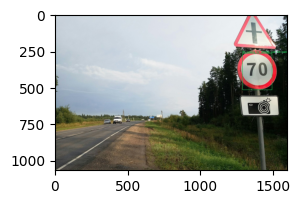

In [16]:
plt.imshow(frame)

In [17]:
from PIL import Image
im = Image.fromarray(frame)
im.save(filename + ".jpeg")

In [18]:
# Releasing video reader and writer
video.release()
writer.release() ## закомментил

## 🏁 FPS results

In [19]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('FPS:', round((f / t), 1))


Total number of frames 1
Total amount of time 37.92117 seconds
FPS: 0.0


In [20]:
# Saving locally without committing
from IPython.display import FileLink
import os

#os.chdir(r'kaggle/working')
FileLink('result.mp4')


C:\Users\Kulinar\Desktop\Линар\ПМИ\3 семестр\DeepLearning\GroupProject\input\result.mp4

# 🔎 Example of the result

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3400968%2Fa57f58b38e3caab6fbf72169895f5074%2Fresult.gif?generation=1585955236302060&alt=media)